In [ ]:
using CUDA, Colors, ColorMatrixConvention

In [ ]:
function generate_kernel(f, img)
    r, c = Int32.(size(img))
    i = threadIdx().x + (blockIdx().x - 1) * blockDim().x
    j = threadIdx().y + (blockIdx().y - 1) * blockDim().y
    
    @inbounds if i <= r && j <= c
        @inline img[i,j] = eltype(img)(f(i,j,r,c))
    end
    return
end

function generate(f, img::CuArray{C}, sync=true) where C<:Colorant
    threads = 16,16
    blocks = cld.(size(img), threads)
        @cuda threads=threads blocks=blocks generate_kernel(f, img)
        if sync
            CUDA.synchronize()
        end
    img
end

generate (generic function with 2 methods)

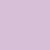

In [4]:
let 
    simple(i,j,r,c) = colorant"thistle"
    
    n = 50
    b = CuArray{RGB{Float32}}(undef, n,n)
    generate(simple, b)
    b
end

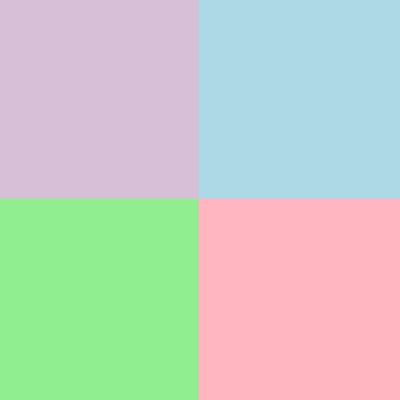

In [5]:
let 
    simple(i,j,r,c) = begin
        if i < r/2 && j < c/2
            colorant"thistle"
        elseif i < r/2 && j >= c/2
            colorant"lightblue"
        elseif i >= r/2 && j < c/2
            colorant"lightgreen"
        else
            colorant"lightpink"
        end
    end
    
    n = 400
    b = CuArray{RGB{Float32}}(undef, n,n)
    generate(simple, b)
    b
end

In [6]:
struct Literal{T} end
Base.:(*)(x, ::Type{Literal{T}}) where {T} = T(x)
const i32 = Literal{Int32}

i32 (alias for Literal{Int32})

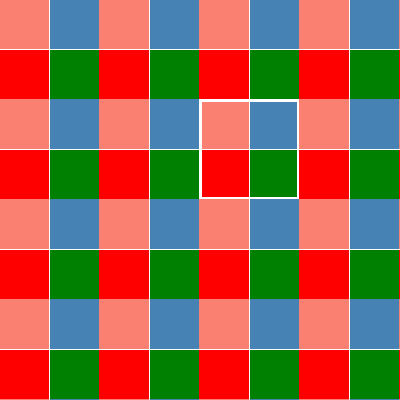

In [7]:
let 
    shader(i,j, r, c) = begin
        i, ii = divrem(i, 100i32)
        j, jj = divrem(j, 100i32)
        if i == 1 && j == 2 && (ii < 3 || jj < 3 || ii > 97 || jj > 97)
            return colorant"white" 
        end

        x  =  Float32(ii - 50i32) / 50.0f0
        y  =  Float32(jj - 50i32) / 50.0f0
        # if abs(x)  + abs(y) - 1.25f0 < 0.0f0
        # 	return colorant"salmon"
        # else 
        # 	return colorant"steelblue"
        # end
        if x < 0.0f0 && y < 0.0f0
            return colorant"salmon"
        elseif x < 0.0f0 && y > 0.0f0
            return colorant"steelblue"
        elseif x > 0.0f0 && y < 0.0f0
            return colorant"red"
        elseif x > 0.0f0 && y > 0.0f0
            return colorant"green"
        else
            return colorant"white"
        end
    end
    n = 400
    b = CuArray{RGB{Float32}}(undef, n,n)
    generate(shader, b)
    b
end

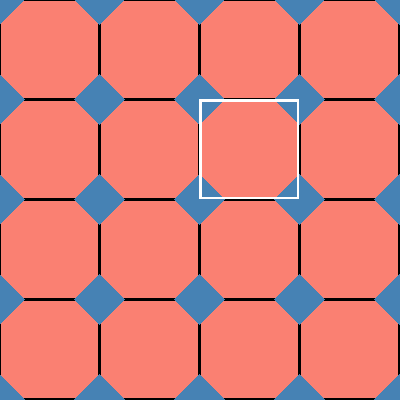

In [8]:
let 
    shader(i,j, r, c) = begin
        i, ii = divrem(i, 100i32)
        j, jj = divrem(j, 100i32)
        if i == 1 && j == 2 && (ii < 3 || jj < 3 || ii > 97 || jj > 97)
            return colorant"white" 
        end

        x  =  Float32(ii - 50i32) / 50.0f0
        y  =  Float32(jj - 50i32) / 50.0f0
        x = abs(x)
        y = abs(y)
        if x  + y - 1.5f0 < 0.0f0
        	if max(x,y) > 0.98
                return colorant"black"
            else
                return colorant"salmon"
            end
        else 
        	return colorant"steelblue"
        end
    end
    n = 400
    b = CuArray{RGB{Float32}}(undef, n,n)
    generate(shader, b)
    b
end

In [9]:
# Hex-grid helpers (pointy-topped, size = 1)  –  Float32 version
const SQRT3_f32 = Float32(sqrt(3.0))          # ≈ 1.7320508f0

"""
    point_to_cube(px, py; size = 1f0) -> (X, Y, Z)

Given a point `(px, py)` in the plane (Float32), return the **integer**
cube coordinates of the hexagon that contains it.
`size` is the centre-to-vertex distance of each hex (Float32, default 1).
"""
function point_to_cube(px::Float32, py::Float32; size::Float32 = 1f0)
    # --- scale away hex size -------------------------------------------------
    px /= size
    py /= size

    # --- fractional cube coordinates ----------------------------------------
    zf = (2f0/3f0) * py
    xf = (SQRT3_f32/3f0) * px - py/3f0
    yf = -xf - zf          # keep the invariant x+y+z = 0

    # --- round to nearest integer cube --------------------------------------
    rx, ry, rz = round(Int, xf), round(Int, yf), round(Int, zf)
    dx, dy, dz = abs(Float32(rx) - xf), abs(Float32(ry) - yf), abs(Float32(rz) - zf)

    if dx > dy && dx > dz
        rx = -ry - rz
    elseif dy > dz
        ry = -rx - rz
    else
        rz = -rx - ry
    end
    return (rx, ry, rz)
end

"""
    local_coords(px, py; size = 1f0) -> ((X,Y,Z), (x′, y′))

Return the containing hex’s cube coords **and**
the local coordinates of the point after translating that hex so its
centre sits at the origin.
"""
function local_coords(px::Float32, py::Float32; size::Float32 = 1f0)
    # 1. Which hex are we in?
    (cx, cy, cz) = point_to_cube(px, py; size)

    # 2. Centre of that hex in world-space
    centre_x = size * (SQRT3_f32 * Float32(cx) + (SQRT3_f32/2f0) * Float32(cz))
    centre_y = size * (1.5f0 * Float32(cz))

    # 3. Local offset relative to translated origin-hex
    local_x = px - centre_x
    local_y = py - centre_y
    return ((cx, cy, cz), (local_x, local_y))
end



local_coords

In [11]:
# ----------------------------- demo ------------------------------------------
point = (Float32(1.4), Float32(0.7))
cube, loc = local_coords(point...; size = 1f0)
println("point $point lies in cube hex $cube")
println("translated offset inside origin hex = $loc")


point (1.4f0, 0.7f0) lies in cube hex (1, -1, 0)
translated offset inside origin hex = (-0.3320508f0, 0.7f0)


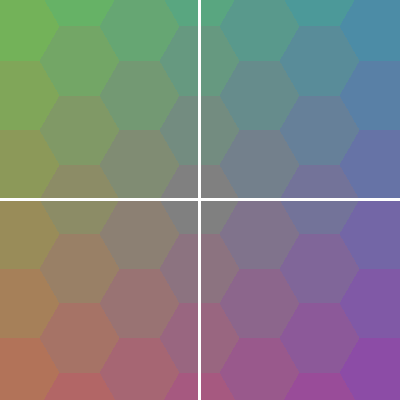

In [24]:
let 
    shader(i, j, r, c) = begin
        if abs(i - r / 2i32) < 2i32 || abs(j - c / 2i32) < 2i32
            return colorant"white"
        end
        
        x  =  Float32(i - r / 2i32) / (r/ 2f0) * 10.0f0
        y  =  Float32(j - c / 2i32) / (r/ 2f0) * 10.0f0
        (hii, hjj, hkk), (xx, yy) = local_coords(x, y, size = 2.0f0)
        deg = atand(xx, yy)
        # if 0.0f0 <= deg < 60.0f0
        #     return colorant"salmon"
        # end
        return RGB{Float32}(0.5f0 + hii/20.0f0, 0.5f0 + hjj/20.0f0, 0.5f0 +hkk/20.0f0)
    end
    n = 400
    b = CuArray{RGB{Float32}}(undef, n,n)
    generate(shader, b)
    b
end